---
#**Telecom Company Churn Analysis**
---

###**Problem Statement**

A Telecom company is very concerned about its customers discontinuing the service and opting to move to the one provided by the competitors. It is a major phenomenon is several service industries and is called ‘Churn’.  The company thinks that there are early indications available in the way a customer uses its service in predicting whether he/she is likely to churn.

###**Dataset**
The dataset is about telecom industry which tells about the number of customers who churned the service. It consists of 3333 observations having 21 variables. We have to predict which customer is going to churn the service.

###**Methodology**

In this case study I approached the dataset as if it were stored in an HDFS cluster combining Spark with essential Python libraries for data manipulation, visualization, and Exploratory Data Analysis (EDA).

To apply basic Python libraries such as Pandas, Matplotlib, and Seaborn, I partitioned the dataset. This mimics the process that would be required for handling very large datasets. After preparing the data I built machine learning classification models such as Decision Tree, Random Forest, and Gradient-Boosted Trees using PySpark to predict customer churn.


####**Why I Chose to Use Google Colab**

Google Colab provides a free and convenient environment for exploring and practicing with PySpark. While this case study involves a relatively small dataset, Colab allows me to simulate the approach I would use for processing large datasets in a distributed environment like HDFS.

PySpark integrates seamlessly with machine learning libraries such as TensorFlow and Scikit-learn, enabling smooth transitions from data processing to model training. I can also test smaller data samples using Pandas for initial analysis and efficiently manage memory throughout the process. This workflow helps me build complete data pipelines, gain hands-on experience with scalable data processing, and prepare for working with big data systems.

In [ ]:
# Acces Google Drive contents
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Initializing and Installing SPARK in Google colab**

In [ ]:

# Step 1: Update system package information
!sudo apt update

# Step 2: Install Java 8 (OpenJDK headless version), which is required to run Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Step 3: check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# Step 4: Install findspark, a Python library to locate the Spark installation
!pip install -q findspark
# Step 5: Install PySpark, the Python API for Spark
!pip install pyspark
# Step 6: Install Py4J, a library that enables Python programs to dynamically access Java objects
!pip install py4j

# Step 7: Import necessary Python libraries
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

# Step 8: Initialize findspark to make sure the system can locate Spark
import findspark
findspark.init() # Initializes findspark with default environment variables
findspark.find() # Confirms the path where Spark is located


#### **Loading Libraries**

In [ ]:
# Libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Import PySpark and initialize Spark session
import pyspark
from pyspark.sql import DataFrame, SparkSession
spark = SparkSession.builder.getOrCreate() # Create SparkSession
sc = spark.sparkContext # For accessing the SparkContext if needed

# PySpark SQL and data types
from pyspark.sql.types import * # For various data types like StringType, IntegerType, etc.
from pyspark.sql import Row # For SparkSession and Row objects
import pyspark.sql.functions as F  # For SQL-like functions such as col(), lit(), etc.

# Suppresses warning messages to keep output cleaner
import warnings
warnings.filterwarnings('ignore')


#### **Read the Data Using Spark**

In [ ]:
churn_data = spark.read.csv('/content/drive/MyDrive/Data Science/Big Data/Telecom Business Churn Analysis/data/Churn.csv', header=True, inferSchema=True)

In [ ]:
churn_data.show()

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|       0|        1|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|       0|        1|     123|    27.47|     103|    16.62|       103|      11.45| 

### **Data Preprocessing**

Few variables which should be of categorical data type but they are of type integer need to be coverted into categorical datatype variables.

* Churn: Customers who churned the telecom service or who doesn’t(0=“Churner”, 1=“ Non-Churner”)
* Int.l.Plan: Does the customer have an international plan or not.
* VMail.Plan: Voicemail plan taken by the customer or not.


In [ ]:
# Converting integer columns to string (categorical)

# Mapping 'Churn' column: 0 = 'Non-Churner', 1 = 'Churner'
ch_conv = churn_data.withColumn('Churn', F.when(F.col('Churn') == 1, 'Churner').otherwise('Non-Churner'))

# Mapping 'VMailPlan' and 'IntlPlan' with 1 = Yes and 0 = No
ch_conv = ch_conv.withColumn('IntlPlan', F.when(F.col('IntlPlan') == 1, 'Yes').otherwise('No'))
ch_conv = ch_conv.withColumn('VMailPlan', F.when(F.col('VMailPlan') == 1, 'Yes').otherwise('No'))

In [ ]:
ch_conv.show()

+-------------+------------+-------+-------+---------+--------+-------------+-----------+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|      Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----------+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|Non-Churner|      No|      Yes|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|Non-Churner|      No|      Yes|     123|    27.47|     103|    

In [ ]:
# Count the total number of rows in the DataFrame
total_rows = ch_conv.count()
print(f"Total number of rows: {total_rows}")

Total number of rows: 3333


In [ ]:
# Count missing values (NULLs) in each column
ch_conv.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ch_conv.columns]).show()

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+-----+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+-----+
|            0|           0|      0|      0|        0|       0|            0|    0|       0|        0|       0|        0|       0|        0|         0|          0|        0|         0|    0|       0|    0|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+---

---
# **Exploratory Data Analysis (EDA)**

To perform Exploratory Data Analysis on our data stored in HDFS, a way to do it is to convert it into a Pandas DataFrame to use libraries like Seaborn and Matplotlib.

**Note:** To be be careful when converting large datasets from HDFS, If the data is too big for the local computer's memory, it can cause performance issues or even crashes. Therefore it is best to select a specific portion of the dataset before converting it to Pandas. This ensures that the data can be efficiently handled, allowing to comfortably apply EDA without overwhelming system resources.

### **Convert into Pandas data frame**

For this specific case study, since we are dealing with a relatively small dataset (3333 rows and 21 columns), we will select the entire dataset using the limit() function, which preserves the data structure. Then we will convert it into a Pandas DataFrame for further analysis.

In [ ]:
# Sample a specific number of rows from the HDFS using pyspark to convert to Pandas.
ch_pandas = ch_conv.limit(3333).toPandas()

#### **Visualizing the converted DataFrame**

In [ ]:
ch_pandas

,AccountLength,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,Churn,IntlPlan,VMailPlan,...,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,State,AreaCode,Phone
0,128,25,265.1,197.4,244.7,10.0,1,Non-Churner,No,Yes,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,Non-Churner,No,Yes,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,Non-Churner,No,No,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,Non-Churner,Yes,No,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,Non-Churner,Yes,No,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,215.5,279.1,9.9,2,Non-Churner,No,Yes,...,26.55,126,18.32,83,12.56,6,2.67,AZ,415,414-4276
3329,68,0,231.1,153.4,191.3,9.6,3,Non-Churner,No,No,...,39.29,55,13.04,123,8.61,4,2.59,WV,415,370-3271
3330,28,0,180.8,288.8,191.9,14.1,2,Non-Churner,No,No,...,30.74,58,24.55,91,8.64,6,3.81,RI,510,328-8230
3331,184,0,213.8,159.6,139.2,5.0,2,Non-Churner,Yes,No,...,36.35,84,13.57,137,6.26,10,1.35,CT,510,364-6381


#### **Summary of Dataframe**

In [ ]:
ch_pandas.describe()

,AccountLength,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,AreaCode
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,200.980348,200.872037,10.237294,1.562856,100.435644,30.562307,100.114311,17.083540,100.107711,9.039325,4.479448,2.764581,437.182418
std,39.822106,13.688365,54.467389,50.713844,50.573847,2.791840,1.315491,20.069084,9.259435,19.922625,4.310668,19.568609,2.275873,2.461214,0.753773,42.371290
min,1.000000,0.000000,0.000000,0.000000,23.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,408.000000
25%,74.000000,0.000000,143.700000,166.600000,167.000000,8.500000,1.000000,87.000000,24.430000,87.000000,14.160000,87.000000,7.520000,3.000000,2.300000,408.000000
50%,101.000000,0.000000,179.400000,201.400000,201.200000,10.300000,1.000000,101.000000,30.500000,100.000000,17.120000,100.000000,9.050000,4.000000,2.780000,415.000000
75%,127.000000,20.000000,216.400000,235.300000,235.300000,12.100000,2.000000,114.000000,36.790000,114.000000,20.000000,113.000000,10.590000,6.000000,3.270000,510.000000
max,243.000000,51.000000,350.800000,363.700000,395.000000,20.000000,9.000000,165.000000,59.640000,170.000000,30.910000,175.000000,17.770000,20.000000,5.400000,510.000000


#### **Observations:**

* High usage variability: There is a significant variation in call usage between customers, especially for day, evening, and night calls.
* Customer Service Calls: A small percentage of customers make a relatively high number of customer service calls (up to 9), which could correlate with dissatisfaction or potential churn.
* Voicemail: A large portion of customers do not seem to be using voicemail services (median VMailMessage is 0).
* Heavy Users: There are customers with exceptionally high usage (max values for minutes and charges), which may represent heavy or premium users.


Create Histogram for Day minutes spent by customers for categorical values churn=0 (Churner) and churn=1 (Non-Churner).

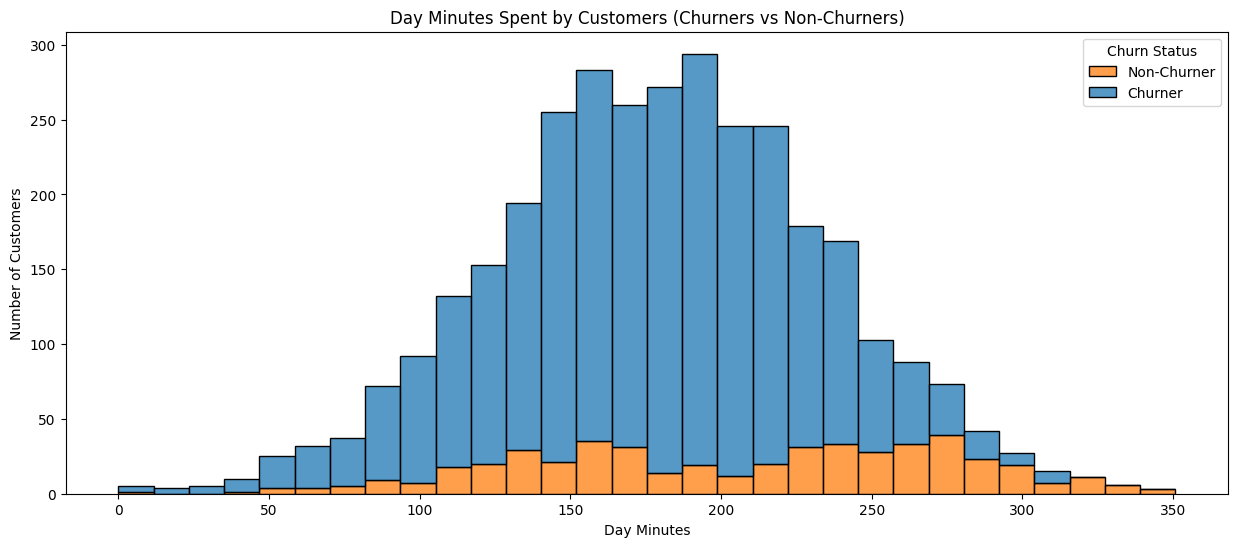

In [ ]:
# Plot histogram for DayMins, separated by Churner and Non-Churner
plt.figure(figsize=(15, 6))
sns.histplot(data=ch_pandas, x='DayMins', hue='Churn', multiple='stack', bins=30)

plt.title('Day Minutes Spent by Customers (Churners vs Non-Churners)')
plt.xlabel('Day Minutes')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status', labels=['Non-Churner', 'Churner'])
plt.show()

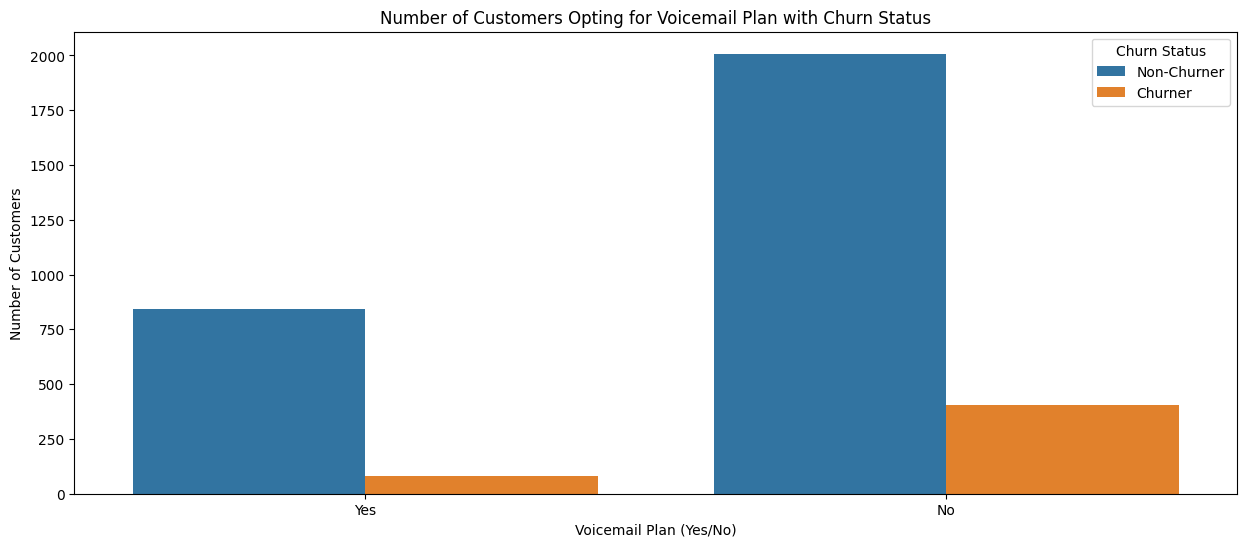

,count
VMailPlan,
No,2411
Yes,922


In [ ]:
# Count plot for Number of customers who opted for voicemail plan, segmented by Churn values
plt.figure(figsize=(15, 6))
sns.countplot(data=ch_pandas, x='VMailPlan', hue='Churn')
plt.title('Number of Customers Opting for Voicemail Plan with Churn Status')
plt.xlabel('Voicemail Plan (Yes/No)')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status', labels=['Non-Churner', 'Churner'])
plt.show()

# Get the counts for Voice Mail Plans column
ch_pandas['VMailPlan'].value_counts()

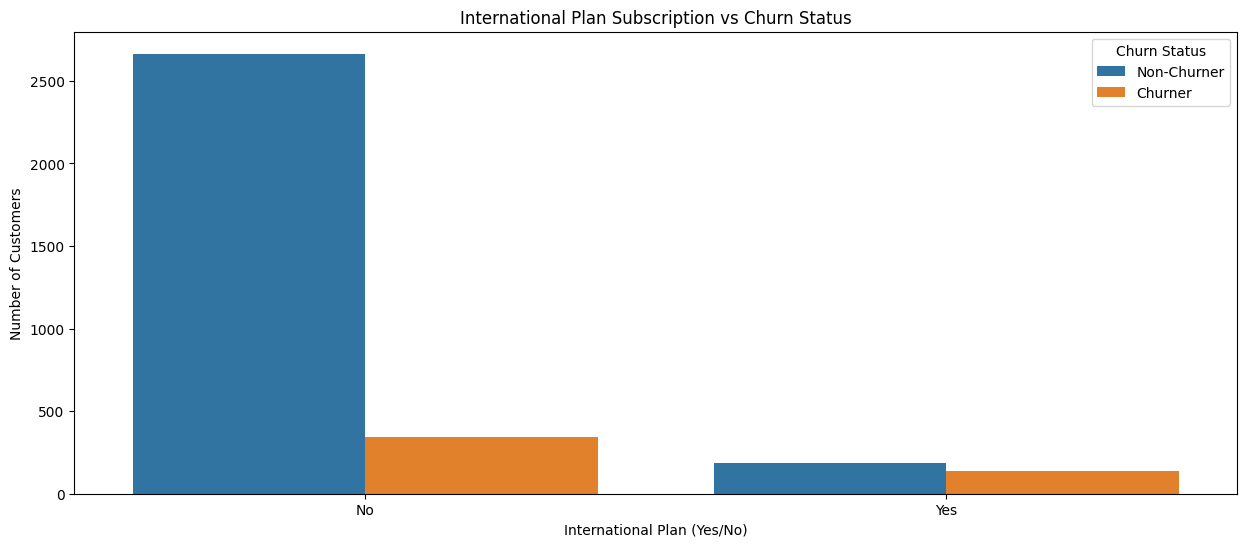

,count
IntlPlan,
No,3010
Yes,323


In [ ]:
# Count plot for International Plan opted by customers, segmented by Churn values
plt.figure(figsize=(15, 6))
sns.countplot(data=ch_pandas, x='IntlPlan', hue='Churn')

plt.title('International Plan Subscription vs Churn Status')
plt.xlabel('International Plan (Yes/No)')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status', labels=['Non-Churner', 'Churner'])
plt.show()

# Get the counts for the International Plans column
ch_pandas['IntlPlan'].value_counts()

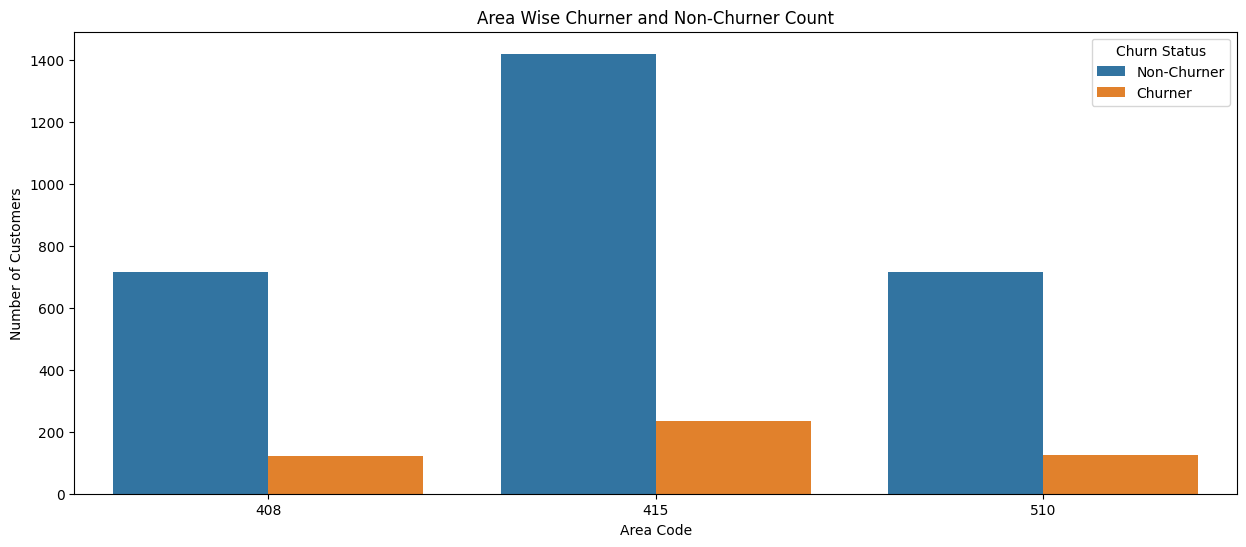

In [ ]:
# Plot Area-wise Churner and Non-Churner count
plt.figure(figsize=(15, 6))
sns.countplot(data=ch_pandas, x='AreaCode', hue='Churn')

plt.title('Area Wise Churner and Non-Churner Count')
plt.xlabel('Area Code')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status', labels=['Non-Churner', 'Churner'])
plt.show()

### **Correlation Matrix**

To perform correlation calculations which require numeric data the categorical variable categorical variables, such as Churn, IntlPlan, and VMailPlan, must be converted to numeric form.

In [ ]:
ch_pandas_correl = ch_pandas

# Convert 'Churn' to numeric values (1 for Churner, 0 for Non-Churner)
ch_pandas_correl['Churn'] = ch_pandas_correl['Churn'].apply(lambda x: 1 if x == 'Churner' else 0)

# Convert 'IntlPlan' to numeric values (1 for Yes, 0 for No)
ch_pandas_correl['IntlPlan'] = ch_pandas_correl['IntlPlan'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert 'VMailPlan' to numeric values (1 for Yes, 0 for No)
ch_pandas_correl['VMailPlan'] = ch_pandas_correl['VMailPlan'].apply(lambda x: 1 if x == 'Yes' else 0)


In [ ]:
# Drop the 'State' and 'Phone' columns, as they are non-numeric
ch_pandas_correl = ch_pandas_correl.drop(columns=['State', 'Phone'])

In [ ]:
ch_pandas_correl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AccountLength  3333 non-null   int32  
 1   VMailMessage   3333 non-null   int32  
 2   DayMins        3333 non-null   float64
 3   EveMins        3333 non-null   float64
 4   NightMins      3333 non-null   float64
 5   IntlMins       3333 non-null   float64
 6   CustServCalls  3333 non-null   int32  
 7   Churn          3333 non-null   int64  
 8   IntlPlan       3333 non-null   int64  
 9   VMailPlan      3333 non-null   int64  
 10  DayCalls       3333 non-null   int32  
 11  DayCharge      3333 non-null   float64
 12  EveCalls       3333 non-null   int32  
 13  EveCharge      3333 non-null   float64
 14  NightCalls     3333 non-null   int32  
 15  NightCharge    3333 non-null   float64
 16  IntlCalls      3333 non-null   int32  
 17  IntlCharge     3333 non-null   float64
 18  AreaCode

#### **Obsevations:**

From the info funtion we can see The dataset (ch_pandas_correl) has 19 numeric columns. The categorical columns (Churn, IntlPlan, and VMailPlan) have been converted to numbers making them ready for correlation analysis. The non-numeric columns (State and Phone) are also removed so we can now calculate the correlation matrix with the remaining data.

### **Correlation Matrix**

In [ ]:
ch_pandas_correl.corr('pearson')

,AccountLength,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,Churn,IntlPlan,VMailPlan,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,AreaCode
AccountLength,1.000000,-0.004628,0.006216,-0.006757,-0.008955,0.009514,-0.003796,0.016541,0.024735,0.002918,0.038470,0.006214,0.019260,-0.006745,-0.013176,-0.008960,0.020661,0.009546,-0.012463
VMailMessage,-0.004628,1.000000,0.000778,0.017562,0.007681,0.002856,-0.013263,-0.089728,0.008745,0.956927,-0.009548,0.000776,-0.005864,0.017578,0.007123,0.007663,0.013957,0.002884,-0.001994
DayMins,0.006216,0.000778,1.000000,0.007043,0.004323,-0.010155,-0.013423,0.205151,0.049396,-0.001684,0.006750,1.000000,0.015769,0.007029,0.022972,0.004300,0.008033,-0.010092,-0.008264
EveMins,-0.006757,0.017562,0.007043,1.000000,-0.012584,-0.011035,-0.012985,0.092796,0.019100,0.021545,-0.021451,0.007050,-0.011430,1.000000,0.007586,-0.012593,0.002541,-0.011067,0.003580
NightMins,-0.008955,0.007681,0.004323,-0.012584,1.000000,-0.015207,-0.009288,0.035493,-0.028905,0.006079,0.022938,0.004324,-0.002093,-0.012592,0.011204,0.999999,-0.012353,-0.015180,-0.005825
IntlMins,0.009514,0.002856,-0.010155,-0.011035,-0.015207,1.000000,-0.009640,0.068239,0.045871,-0.001318,0.021565,-0.010157,0.008703,-0.011043,-0.013605,-0.015214,0.032304,0.999993,-0.018288
CustServCalls,-0.003796,-0.013263,-0.013423,-0.012985,-0.009288,-0.009640,1.000000,0.208750,-0.024522,-0.017824,-0.018942,-0.013427,0.002423,-0.012987,-0.012802,-0.009277,-0.017561,-0.009675,0.027572
Churn,0.016541,-0.089728,0.205151,0.092796,0.035493,0.068239,0.208750,1.000000,0.259852,-0.102148,0.018459,0.205151,0.009233,0.092786,0.006141,0.035496,-0.052844,0.068259,0.006174
IntlPlan,0.024735,0.008745,0.049396,0.019100,-0.028905,0.045871,-0.024522,0.259852,1.000000,0.006006,0.003755,0.049398,0.006114,0.019106,0.012451,-0.028913,0.017366,0.045780,0.048551
VMailPlan,0.002918,0.956927,-0.001684,0.021545,0.006079,-0.001318,-0.017824,-0.102148,0.006006,1.000000,-0.011086,-0.001686,-0.006444,0.021559,0.015553,0.006064,0.007618,-0.001276,-0.000747


#### **Correlation between Predicting Variable and independent variable.**

Now that we want to predict which customer is going to churn, let’s see what columns might be interesting for our prediction. One way is to find the correlation between "Churn" and each of the other columns. This will show us which other columns might predict "Churn" the best.

In [ ]:
ch_pandas_correl.corr()["Churn"]

,Churn
AccountLength,0.016541
VMailMessage,-0.089728
DayMins,0.205151
EveMins,0.092796
NightMins,0.035493
IntlMins,0.068239
CustServCalls,0.208750
Churn,1.000000
IntlPlan,0.259852
VMailPlan,-0.102148


#### **Observations and Insights:**

Overall, the correlations are weak which suggests that no single feature alone strongly drives customer churn and a combination of factors might need to be analyzed further to understand customer behavior better.

---
# **Applying Machine Learning Models such as:**
* Decision-Tree
* Random-Forest
* Gradient-Boosting
---

#### **Import the necessary Spark ML libraries**

In [ ]:
# PySpark ML libraries
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

####**Combining Independent Variables into Feature Vectors Using VectorAssembler**
Using VectorAssembler to combine independent variables into a single vector column called 'features'.

In [ ]:
# List of independent columns (excluding 'Churn', the target column)
input_columns = ['AccountLength', 'VMailMessage', 'DayMins', 'EveMins', 'NightMins',
                 'IntlMins', 'CustServCalls', 'IntlPlan', 'VMailPlan', 'DayCalls',
                 'DayCharge', 'EveCalls', 'EveCharge', 'NightCalls', 'NightCharge',
                 'IntlCalls', 'IntlCharge']

# Create a VectorAssembler to combine independent variables into a single vector column
vector_assembler = VectorAssembler(inputCols=input_columns, outputCol='features')

###**Applying Stratified Sampling**
Using stratified sampling will to ensure that churned and non-churned customers are fairly represented in the training dataset. It selects 80% of each class (churned and non-churned) for training, ensuring balance between the two groups. The remaining data is used as the test set, and the class distribution is checked to confirm the balance is maintained.


In [ ]:
# Calculating the churn class distribution in the original data
churn_distribution = churn_data.groupBy('Churn').count().collect()

# Creating a dictionary to store the count of churners and non-churners
churn_counts = {row['Churn']: row['count'] for row in churn_distribution}
total_count = sum(churn_counts.values())

# Defining fractions for stratified sampling (you can adjust fractions as needed)
fractions = {0: 0.8, 1: 0.8}  # 80% of each class (churners and non-churners) for training

#### **Split Data with Stratified Sampling for Balanced Train and Test Sets in Churn Data**
Applying stratified sampling to create balanced training and test datasets based on customer churn and checking the class distribution to ensure the proportions of churned and non-churned customers are maintained.


In [ ]:
# Applying stratified sampling to get a sample of the data for the training set
train_data_stratified = churn_data.sampleBy('Churn', fractions=fractions, seed=42)

# Subtracting the training set from the original data to get the remaining test set
test_data_stratified = churn_data.subtract(train_data_stratified)

# Checking the distribution in the sampled datasets to ensure class balance is maintained
print('Train data distribution of churned=1 and non-churned=0:')
train_data_stratified.groupBy('Churn').count().show()
print('Test data distribution of churned=1 and non-churned=0:')
test_data_stratified.groupBy('Churn').count().show()

Train data distribution of churned=1 and non-churned=0:
+-----+-----+
|Churn|count|
+-----+-----+
|    1|  389|
|    0| 2329|
+-----+-----+

Test data distribution of churned=1 and non-churned=0:
+-----+-----+
|Churn|count|
+-----+-----+
|    1|   94|
|    0|  521|
+-----+-----+



####**Initialize Evaluators for Model Performance Metrics**
Initializing evaluators to measure models performances using (accuracy, precision and recall) based on the Churn prediction results.

In [ ]:
# Initialize evaluator for Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')
# Initialize evaluator for Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='weightedPrecision')
# Initialize evaluator for Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='weightedRecall')

---
##**Decision-Tree Classifier**
---

####**Initialize Decision-Tree Classifier**
Defining the Decision-TreeClassifier with Churn as the dependent variable and the independent variables as those combined in the features column.

In [ ]:
# Initialize Decision Tree Classifier
decision_tree = DecisionTreeClassifier(labelCol='Churn', featuresCol='features')

#### **Creating a pipeline to build the classifier**

A pipeline is created that includes the VectorAssembler and the Decision-Tree Classifier connecting all steps needed to build the model.

In [ ]:
# Create pipeline for Decision Tree
pipeline_dt = Pipeline(stages=[vector_assembler, decision_tree])

####**Train the Decision-Tree Model and Make Predictions (on the training data)**
The pipeline is fit to the training data to train the Decision Tree model. Once trained predictions are made on the same training data to assess model performance.

In [ ]:
# Fit Decision Tree model on training data
model_dt = pipeline_dt.fit(train_data_stratified)

# Make predictions on training data
train_predictions_dt = model_dt.transform(train_data_stratified)

####**Evaluate Decision Tree Model Performance on Training Data**
The model's performance is evaluated on the training data by calculating three key metrics (Accuracy, Precision, Recall) which provide insights into the model's effectiveness in predicting the Churn variable.

In [ ]:
# Calculate accuracy for Decision Tree
train_accuracy_dt = accuracy_evaluator.evaluate(train_predictions_dt)
print(f"Decision Tree Training Accuracy: {train_accuracy_dt * 100:.2f}%")


# Calculate precision for Decision Tree
train_precision_dt = precision_evaluator.evaluate(train_predictions_dt)
print(f"Decision Tree Training Precision: {train_precision_dt * 100:.2f}%")

# Calculate recall for Decision Tree
train_recall_dt = recall_evaluator.evaluate(train_predictions_dt)
print(f"Decision Tree Training Recall: {train_recall_dt * 100:.2f}%")

Decision Tree Training Accuracy: 94.44%
Decision Tree Training Precision: 94.25%
Decision Tree Training Recall: 94.44%


####**Make Predictions and Evaluate Decision-Tree Model on Test Data**
The trained Decision-Tree model is used to make predictions on the unseen test data. The model's performance is then evaluated by calculating the (Accuracy, Precision and Recall) scores.

In [ ]:
# Make predictions on test data for Decision Tree
test_predictions_dt = model_dt.transform(test_data_stratified)

# Calculate accuracy for Decision Tree on test data
test_accuracy_dt = accuracy_evaluator.evaluate(test_predictions_dt)
print(f"Decision Tree Test Accuracy: {test_accuracy_dt * 100:.2f}%")

# Calculate precision for Decision Tree on test data
test_precision_dt = precision_evaluator.evaluate(test_predictions_dt)
print(f"Decision Tree Test Precision: {test_precision_dt * 100:.2f}%")

# Calculate recall for Decision Tree on test data
test_recall_dt = recall_evaluator.evaluate(test_predictions_dt)
print(f"Decision Tree Test Recall: {test_recall_dt * 100:.2f}%")


Decision Tree Test Accuracy: 94.31%
Decision Tree Test Precision: 94.39%
Decision Tree Test Recall: 94.31%


---
## **Random-Forest Classifier**
---

#### **Initialize Random-Forest Classifier**
A Random-ForestClassifier is initialized with "Churn" as the dependent variable and the independent variables combined in the "features" column for model training and predictions.

In [ ]:
# Initialize Random Forest Classifier
random_forest = RandomForestClassifier(labelCol='Churn', featuresCol='features')

#### **Creating a pipeline to build the classifier**

In [ ]:
# Create pipeline for Random Forest
pipeline_rf = Pipeline(stages=[vector_assembler, random_forest])

#### **Train the Random-Forest Model and make Predictions (on the training data)**

In [ ]:
# Fit Random Forest model on training data
model_rf = pipeline_rf.fit(train_data_stratified)

# Make predictions on training data
train_predictions_rf = model_rf.transform(train_data_stratified)

#### **Evaluate Random-Forest Model Performance on Training Data**

In [ ]:
# Calculate accuracy for Random Forest
train_accuracy_rf = accuracy_evaluator.evaluate(train_predictions_rf)
print(f"Random Forest Training Accuracy: {train_accuracy_rf * 100:.2f}%")

# Calculate precision for Random Forest
train_precision_rf = precision_evaluator.evaluate(train_predictions_rf)
print(f"Random Forest Training Precision: {train_precision_rf * 100:.2f}%")

# Calculate recall for Random Forest
train_recall_rf = recall_evaluator.evaluate(train_predictions_rf)
print(f"Random Forest Training Recall: {train_recall_rf * 100:.2f}%")


Random Forest Training Accuracy: 92.46%
Random Forest Training Precision: 92.69%
Random Forest Training Recall: 92.46%


#### **Make Predictions and Evaluate Random-Forest Model on Test Data**

In [ ]:
# Make predictions on test data for Random Forest
test_predictions_rf = model_rf.transform(test_data_stratified)

# Calculate accuracy for Random Forest on test data
test_accuracy_rf = accuracy_evaluator.evaluate(test_predictions_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf * 100:.2f}%")

# Calculate precision for Random Forest on test data
test_precision_rf = precision_evaluator.evaluate(test_predictions_rf)
print(f"Random Forest Test Precision: {test_precision_rf * 100:.2f}%")

# Calculate recall for Random Forest on test data
test_recall_rf = recall_evaluator.evaluate(test_predictions_rf)
print(f"Random Forest Test Recall: {test_recall_rf * 100:.2f}%")


Random Forest Test Accuracy: 90.89%
Random Forest Test Precision: 90.79%
Random Forest Test Recall: 90.89%


---
## **Gradient-Boosted Tree Classifier**
---

#### **Initialize Gradient-Boosted Tree Classifier**
A Gradient-Boosted Tree Classifier is initialized with "Churn" as the target variable and the independent variables combined in the "features" column for training and predictions.

In [ ]:
# Initialize Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol='Churn', featuresCol='features')

####**Creating a pipeline to build the classifier**

In [ ]:
# Create pipeline for Gradient-Boosted Tree
pipeline_gbt = Pipeline(stages=[vector_assembler, gbt])

####**Train the Gradient-Boost Model and make Predictions (on the training data)**

In [ ]:
# Fit Gradient-Boosted Tree model on training data
model_gbt = pipeline_gbt.fit(train_data_stratified)

# Make predictions on training data
train_predictions_gbt = model_gbt.transform(train_data_stratified)

#### **Evaluate Gradient-Boost Model Performance on Training Data**

In [ ]:
# Calculate accuracy for Gradient-Boosted Tree
train_accuracy_gbt = accuracy_evaluator.evaluate(train_predictions_gbt)
print(f"Gradient-Boosted Tree Training Accuracy: {train_accuracy_gbt * 100:.2f}%")

# Calculate precision for Gradient-Boosted Tree
train_precision_gbt = precision_evaluator.evaluate(train_predictions_gbt)
print(f"Gradient-Boosted Tree Training Precision: {train_precision_gbt * 100:.2f}%")

# Calculate recall for Gradient-Boosted Tree
train_recall_gbt = recall_evaluator.evaluate(train_predictions_gbt)
print(f"Gradient-Boosted Tree Training Recall: {train_recall_gbt * 100:.2f}%")


Gradient-Boosted Tree Training Accuracy: 97.35%
Gradient-Boosted Tree Training Precision: 97.36%
Gradient-Boosted Tree Training Recall: 97.35%


####**Make Predictions and Evaluate Gradient-Boost Model on Test Data**

In [ ]:
# Make predictions on test data for Gradient-Boosted Tree
test_predictions_gbt = model_gbt.transform(test_data_stratified)

# Calculate accuracy for Gradient-Boosted Tree on test data
test_accuracy_gbt = accuracy_evaluator.evaluate(test_predictions_gbt)
print(f"Gradient-Boosted Tree Test Accuracy: {test_accuracy_gbt * 100:.2f}%")

# Calculate precision for Gradient-Boosted Tree on test data
test_precision_gbt = precision_evaluator.evaluate(test_predictions_gbt)
print(f"Gradient-Boosted Tree Test Precision: {test_precision_gbt * 100:.2f}%")

# Calculate recall for Gradient-Boosted Tree on test data
test_recall_gbt = recall_evaluator.evaluate(test_predictions_gbt)
print(f"Gradient-Boosted Tree Test Recall: {test_recall_gbt * 100:.2f}%")


Gradient-Boosted Tree Test Accuracy: 96.10%
Gradient-Boosted Tree Test Precision: 96.10%
Gradient-Boosted Tree Test Recall: 96.10%


---
##**Observations and Insights:**
---
####**Model Performance Comparison:**

**Decision Tree (DT):**

* Test Accuracy: 94.31%
* Test Precision: 94.39%
* Test Recall: 94.31%

**Random Forest (RF):**

* Test Accuracy: 90.89%
* Test Precision: 90.79%
* Test Recall: 90.89%

**Gradient-Boosted Trees (GBT):**

* Test Accuracy: 96.10%
* Test Precision: 96.10%
* Test Recall: 96.10%



---
###**How Features Could Influence Churn**
Understanding which features influence churn can help the company prioritize their efforts of holding a customer.

From the Exploratory Data Analysis i chose the folowing features because they showed the strongest correlations with churn and may have a clear business relevance for understanding why customers might leave.

* **International Plan:** It had the highest positive correlation with churn (0.259852), meaning customers with this plan are more likely to leave. This feature is also intuitively important because plans with extra costs often contribute to churn.

* **Customer Service Calls:** This feature with a correlation with churn (0.208750), indicating that customers who frequently contact support are likely unhappy and more likely to leave.

* **Daytime Minutes and Charges:** Both DayMins and DayCharge had a correlation of 0.205151 with churn. High daytime usage or costs could lead customers to feel their bills are too high, increasing churn risk.

####**How the ML Models Potentially Interacted with the Features**

* **International Plan:** The models likely considered whether having this plan increased the likelihood of churn.
* **Customer Service Calls:** More calls to customer service would have been a strong indicator for the models that a customer might leave.
* **Daytime Minutes/Charges:** High daytime usage or charges helped the models identify patterns linked to churn.




---
###**Conclusion:**
Gradient-Boosted Trees (GBT) is the most accurate model, with 96.10% accuracy, precision, and recall, making it the best for predicting customer churn. However it's complex and hard to explain to non technical people, so it work well only when prediction accuracy is more important than understanding the reasons behind churn.

Decision Tree (DT) is slightly less accurate, at 94.31%, but it’s much easier to understand and explain. If the Telecom company needs to know why customers are likely to leave this is a better choice because it provides clear insights into the reasons behind each prediction.

Random Forest (RF) while decent with 90.89% accuracy it doesn’t perform as well as the other two models so it's not the best option in this case scenario.


---

Christos Parapanisios - christosparapanisios@gmail.com

---